In [2]:
# Import libraries 
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import pyvis
import random
import itertools
import kuzu
import duckdb

In [3]:
# Create graph model based on Cypher script

# Create a directed graph
G = nx.DiGraph()

# Add nodes with attributes
nodes = [
    ('Dairy Farm A', {'type': 'FARM', 'co2_emission': 5000}),
    ('Cheese Factory A', {'type': 'FACTORY', 'co2_emission': 2000}),
    ('Cheese Distributor B', {'type': 'DISTRIBUTION', 'co2_emission': 380}),
    ('Cheese Factory C', {'type': 'FACTORY', 'co2_emission': 2100}),
    ('Starter Culture Co B', {'type': 'SUPPLIER', 'co2_emission': 250}),
    ('Media Culture B', {'type': 'MEDIA', 'co2_emission': 230}),
    ('Dairy Farm B', {'type': 'FARM', 'co2_emission': 4500}),
    ('Cheese Factory B', {'type': 'FACTORY', 'co2_emission': 1800}),
    ('Cheese Distributor A', {'type': 'DISTRIBUTION', 'co2_emission': 400}),
    ('Final Product Cheese', {'type': 'FINAL_PRODUCT', 'co2_emission': None}),
    ('Dairy Farm C', {'type': 'FARM', 'co2_emission': 5200}),
    ('Salt Supplier B', {'type': 'SUPPLIER', 'co2_emission': 140}),
    ('Media Culture A', {'type': 'MEDIA', 'co2_emission': 250}),
    ('Starter Culture Co A', {'type': 'SUPPLIER', 'co2_emission': 300}),
    ('Salt Supplier A', {'type': 'SUPPLIER', 'co2_emission': 150}),
    ('Salt Supplier C', {'type': 'SUPPLIER', 'co2_emission': 160}),
    ('Packaging Co', {'type': 'SUPPLIER', 'co2_emission': 120}),
]

G.add_nodes_from(nodes)

# Add edges with attributes
edges = [
    ('Dairy Farm A', 'Cheese Factory A', {'co2_emission': 54.38}),
    ('Cheese Factory A', 'Cheese Distributor B', {'co2_emission': 1044.32}),
    ('Cheese Factory C', 'Cheese Distributor B', {'co2_emission': 1212.87}),
    ('Starter Culture Co B', 'Cheese Factory C', {'co2_emission': 3.18}),
    ('Media Culture B', 'Starter Culture Co B', {'co2_emission': 2.47}),
    ('Dairy Farm B', 'Cheese Factory B', {'co2_emission': 53.69}),
    ('Cheese Factory B', 'Cheese Distributor A', {'co2_emission': 1075.97}),
    ('Cheese Distributor A', 'Final Product Cheese', {'co2_emission': 94.75}),
    ('Cheese Distributor B', 'Final Product Cheese', {'co2_emission': 72.87}),
    ('Dairy Farm C', 'Cheese Factory C', {'co2_emission': 58.84}),
    ('Salt Supplier B', 'Cheese Factory C', {'co2_emission': 16.63}),
    ('Media Culture A', 'Starter Culture Co A', {'co2_emission': 2.71}),
    ('Starter Culture Co A', 'Cheese Factory B', {'co2_emission': 3.69}),
    ('Salt Supplier A', 'Cheese Factory B', {'co2_emission': 11.09}),
    ('Starter Culture Co B', 'Cheese Factory A', {'co2_emission': 2.15}),
    ('Salt Supplier C', 'Cheese Factory A', {'co2_emission': 15.21}),
    ('Packaging Co', 'Cheese Factory B', {'co2_emission': 4.99}),
    ('Packaging Co', 'Cheese Factory A', {'co2_emission': 4.9}),
    ('Packaging Co', 'Cheese Factory C', {'co2_emission': 4.78}),
]

G.add_edges_from(edges)

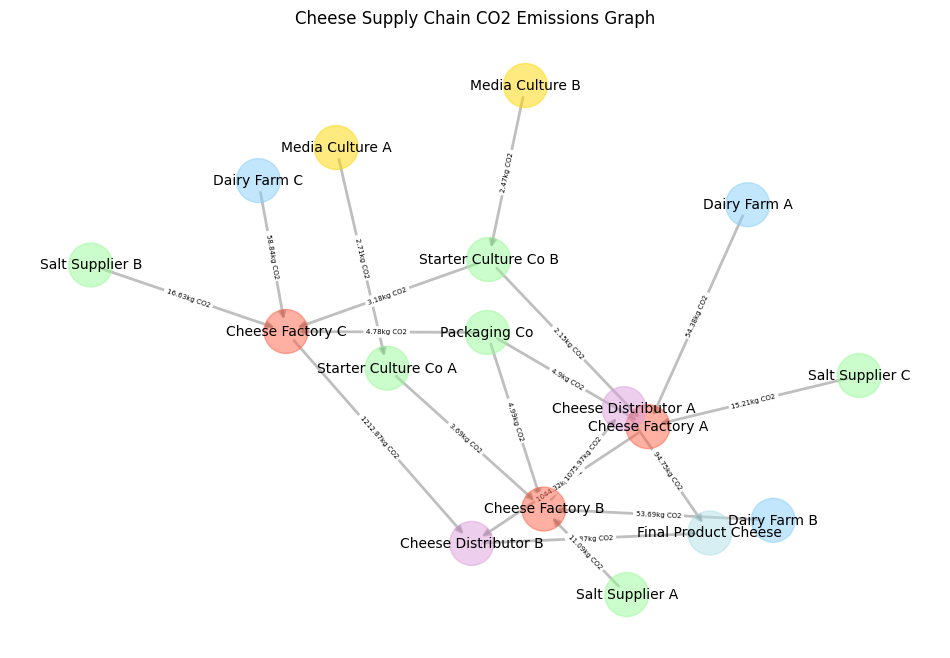

In [4]:
# Visualize the graph model

# Update node colors
node_colors = ["#87CEFA" if G.nodes[node]['type'] == "FARM" else
               "#FF6347" if G.nodes[node]['type'] == "FACTORY" else
               "#98FB98" if G.nodes[node]['type'] == "SUPPLIER" else
               "#FFD700" if G.nodes[node]['type'] == "MEDIA" else
               "#DDA0DD" if G.nodes[node]['type'] == "DISTRIBUTION" else
               "#B0E0E6" if G.nodes[node]['type'] == "FINAL_PRODUCT" else "#FFFFFF" for node in G.nodes]

# Visualize the graph with labels
pos = nx.spring_layout(G, seed=42, k=0.5)  # Position nodes
plt.figure(figsize=(12, 8))

# Draw nodes with labels and colors
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1000, alpha=0.5)

# Draw the edges with labels for CO2 emissions
nx.draw_networkx_edges(G, pos, edgelist=edges, width=2, alpha=0.5, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10)

# Edge labels for CO2 emissions
edge_labels = {(u, v): f"{round(d['co2_emission'], 2)}kg CO2" if d['co2_emission'] is not None else "No CO2 data"
               for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=5)

plt.title("Cheese Supply Chain CO2 Emissions Graph")
plt.axis("off")
plt.show()

In [3]:
# Create an embedded graph database using Kuzú

# Initialize the database
db = kuzu.Database("./co2emissions.db")
conn = kuzu.Connection(db)

In [5]:
# Create schema
conn.execute("CREATE NODE TABLE Farm(name STRING, co2_emission FLOAT, PRIMARY KEY (name))")
conn.execute("CREATE NODE TABLE Factory(name STRING, co2_emission FLOAT, PRIMARY KEY (name))")
conn.execute("CREATE NODE TABLE Supplier(name STRING, co2_emission FLOAT, PRIMARY KEY (name))")
conn.execute("CREATE NODE TABLE Media(name STRING, co2_emission FLOAT, PRIMARY KEY (name))")
conn.execute("CREATE NODE TABLE Distributor(name STRING, co2_emission FLOAT, PRIMARY KEY (name))")
conn.execute("CREATE NODE TABLE FinalProduct(name STRING, co2_emission FLOAT, PRIMARY KEY (name))")

conn.execute("CREATE REL TABLE Supplies_Farm_To_Factory(FROM Farm TO Factory, co2_emission FLOAT)")
conn.execute("CREATE REL TABLE Supplies_Supplier_To_Factory(FROM Supplier TO Factory, co2_emission FLOAT)")
conn.execute("CREATE REL TABLE Supplies_Media_To_Supplier(FROM Media TO Supplier, co2_emission FLOAT)")
conn.execute("CREATE REL TABLE Supplies_Factory_To_Distributor(FROM Factory TO Distributor, co2_emission FLOAT)")
conn.execute("CREATE REL TABLE Delivers(FROM Distributor TO FinalProduct, co2_emission FLOAT)")

# Populate nodes
farms = [
    ("Dairy Farm A", 5000),
    ("Dairy Farm B", 4500),
    ("Dairy Farm C", 5200)
]

factories = [
    ("Cheese Factory A", 2000),
    ("Cheese Factory B", 1800),
    ("Cheese Factory C", 2100)
]

suppliers = [
    ("Starter Culture Co A", 300),
    ("Starter Culture Co B", 250),
    ("Salt Supplier A", 150),
    ("Salt Supplier B", 140),
    ("Salt Supplier C", 160),
    ("Packaging Co", 120)
]

media = [
    ("Media Culture A", 250),
    ("Media Culture B", 230)
]

distributors = [
    ("Cheese Distributor A", 400),
    ("Cheese Distributor B", 380)
]

final_products = [
    ("Cheese", None)
]

for farm in farms:
    conn.execute(f"CREATE (n:Farm {{name: '{farm[0]}', co2_emission: {farm[1]}}})")

for factory in factories:
    conn.execute(f"CREATE (n:Factory {{name: '{factory[0]}', co2_emission: {factory[1]}}})")

for supplier in suppliers:
    conn.execute(f"CREATE (n:Supplier {{name: '{supplier[0]}', co2_emission: {supplier[1]}}})")

for medium in media:
    conn.execute(f"CREATE (n:Media {{name: '{medium[0]}', co2_emission: {medium[1]}}})")

for distributor in distributors:
    conn.execute(f"CREATE (n:Distributor {{name: '{distributor[0]}', co2_emission: {distributor[1]}}})")

for final_product in final_products:
    co2_emission_value = "NULL" if final_product[1] is None else final_product[1]
    conn.execute(f"CREATE (n:FinalProduct {{name: '{final_product[0]}', co2_emission: {co2_emission_value}}})")

# Populate edges
farm_factory_rels = [
    ("Dairy Farm A", "Cheese Factory A", 54.38),
    ("Dairy Farm B", "Cheese Factory B", 53.69),
    ("Dairy Farm C", "Cheese Factory C", 58.84)
]

supplier_factory_rels = [
    ("Starter Culture Co A", "Cheese Factory B", 3.69),
    ("Starter Culture Co B", "Cheese Factory A", 2.15),
    ("Starter Culture Co B", "Cheese Factory C", 3.18),
    ("Salt Supplier A", "Cheese Factory B", 11.09),
    ("Salt Supplier B", "Cheese Factory C", 16.63),
    ("Salt Supplier C", "Cheese Factory A", 15.21),
    ("Packaging Co", "Cheese Factory A", 4.90),
    ("Packaging Co", "Cheese Factory B", 4.99),
    ("Packaging Co", "Cheese Factory C", 4.78)
]

media_supplier_rels = [
    ("Media Culture A", "Starter Culture Co A", 2.71),
    ("Media Culture B", "Starter Culture Co B", 2.47)
]

factory_distributor_rels = [
    ("Cheese Factory A", "Cheese Distributor B", 1044.32),
    ("Cheese Factory B", "Cheese Distributor A", 1075.97),
    ("Cheese Factory C", "Cheese Distributor B", 1212.87)
]

distributor_final_product_rels = [
    ("Cheese Distributor A", "Cheese", 94.75),
    ("Cheese Distributor B", "Cheese", 72.87)
]

for rel in farm_factory_rels:
    conn.execute(f"MATCH (a:Farm {{name: '{rel[0]}'}}), (b:Factory {{name: '{rel[1]}'}}) CREATE (a)-[:Supplies_Farm_To_Factory {{co2_emission: {rel[2]}}}]->(b)")

for rel in supplier_factory_rels:
    conn.execute(f"MATCH (a:Supplier {{name: '{rel[0]}'}}), (b:Factory {{name: '{rel[1]}'}}) CREATE (a)-[:Supplies_Supplier_To_Factory {{co2_emission: {rel[2]}}}]->(b)")

for rel in media_supplier_rels:
    conn.execute(f"MATCH (a:Media {{name: '{rel[0]}'}}), (b:Supplier {{name: '{rel[1]}'}}) CREATE (a)-[:Supplies_Media_To_Supplier {{co2_emission: {rel[2]}}}]->(b)")

for rel in factory_distributor_rels:
    conn.execute(f"MATCH (a:Factory {{name: '{rel[0]}'}}), (b:Distributor {{name: '{rel[1]}'}}) CREATE (a)-[:Supplies_Factory_To_Distributor {{co2_emission: {rel[2]}}}]->(b)")

for rel in distributor_final_product_rels:
    conn.execute(f"MATCH (a:Distributor {{name: '{rel[0]}'}}), (b:FinalProduct {{name: '{rel[1]}'}}) CREATE (a)-[:Delivers {{co2_emission: {rel[2]}}}]->(b)")

In [4]:
# Find the factory that will lead to the path with the least CO2 emissions 
response = conn.execute(
    """
// Step 1: Calculate the cumulative CO2 emissions for each factory, including inbound paths
MATCH (f:Factory)
OPTIONAL MATCH p=(inbound)-[*]->(f)
WITH f, 
     COLLECT(p) AS paths
UNWIND paths AS path
UNWIND NODES(path) AS n
UNWIND RELS(path) AS r
WITH f, 
     SUM(DISTINCT COALESCE(n.co2_emission, 0)) + SUM(DISTINCT r.co2_emission) AS inbound_co2_emission
WITH f, inbound_co2_emission

// Step 2: Calculate the total CO2 emissions for the paths from each factory to the final product
MATCH path = (f)-[*]->(c:FinalProduct {name: 'Cheese'})
UNWIND NODES(path) AS n
UNWIND RELS(path) AS r
WITH f, inbound_co2_emission, 
     SUM(DISTINCT COALESCE(n.co2_emission, 0)) + SUM(DISTINCT r.co2_emission) AS path_co2_emission
WITH f, inbound_co2_emission + path_co2_emission  - f.co2_emission AS total_path_co2
RETURN f.name, total_path_co2
ORDER BY total_path_co2 ASC
    """
)
response.get_as_df()

,f.name,total_path_co2
0,Cheese Factory B,8766.889648
1,Cheese Factory A,9336.299805
2,Cheese Factory C,9791.639648


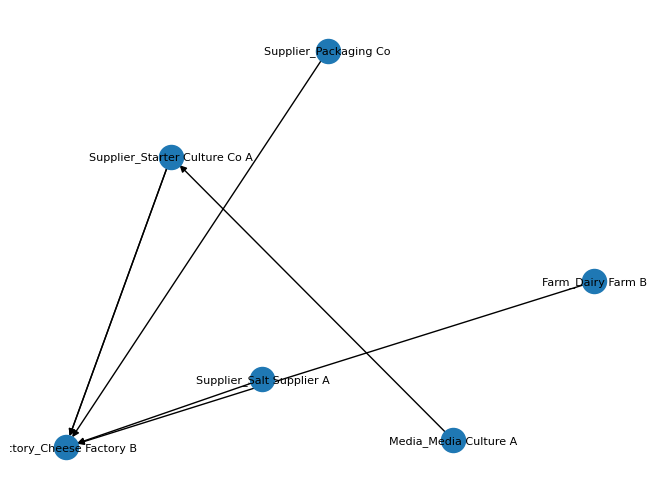

In [22]:
# Get cypher query for all inbound paths to cheese factory B and return it as a NetworkX object
response = conn.execute("""
MATCH (f:Factory {name:'Cheese Factory B'})
OPTIONAL MATCH p=(inbound)-[*]->(f)
RETURN *
""")
H = response.get_as_networkx()

# Visualize the paths atively in networkX
nx.draw(H, with_labels = True, font_size=8)
plt.show()

In [5]:
# Connect to DuckDB embedded OLAP database
con = duckdb.connect('co2emissions.duckdb')

In [3]:
# Create the relational model

con.execute("""
CREATE TABLE farms (
    id INTEGER PRIMARY KEY,
    name TEXT,
    co2_emission FLOAT
)
""")

con.execute("""
CREATE TABLE factories (
    id INTEGER PRIMARY KEY,
    name TEXT,
    co2_emission FLOAT
)
""")

con.execute("""
CREATE TABLE suppliers (
    id INTEGER PRIMARY KEY,
    name TEXT,
    co2_emission FLOAT
)
""")

con.execute("""
CREATE TABLE media (
    id INTEGER PRIMARY KEY,
    name TEXT,
    co2_emission FLOAT
)
""")

con.execute("""
CREATE TABLE distributors (
    id INTEGER PRIMARY KEY,
    name TEXT,
    co2_emission FLOAT
)
""")

con.execute("""
CREATE TABLE final_product (
    id INTEGER PRIMARY KEY,
    name TEXT,
    co2_emission FLOAT
)
""")

# Create bridge tables for relationships
con.execute("""
CREATE TABLE farm_factory (
    id INTEGER PRIMARY KEY,
    farm_id INTEGER,
    factory_id INTEGER,
    co2_emission FLOAT,
    FOREIGN KEY (farm_id) REFERENCES farms(id),
    FOREIGN KEY (factory_id) REFERENCES factories(id)
)
""")

con.execute("""
CREATE TABLE factory_distributor (
    id INTEGER PRIMARY KEY,
    factory_id INTEGER,
    distributor_id INTEGER,
    co2_emission FLOAT,
    FOREIGN KEY (factory_id) REFERENCES factories(id),
    FOREIGN KEY (distributor_id) REFERENCES distributors(id)
)
""")

con.execute("""
CREATE TABLE supplier_factory (
    id INTEGER PRIMARY KEY,
    supplier_id INTEGER,
    factory_id INTEGER,
    co2_emission FLOAT,
    FOREIGN KEY (supplier_id) REFERENCES suppliers(id),
    FOREIGN KEY (factory_id) REFERENCES factories(id)
)
""")

con.execute("""
CREATE TABLE media_supplier (
    id INTEGER PRIMARY KEY,
    media_id INTEGER,
    supplier_id INTEGER,
    co2_emission FLOAT,
    FOREIGN KEY (media_id) REFERENCES media(id),
    FOREIGN KEY (supplier_id) REFERENCES suppliers(id)
)
""")

con.execute("""
CREATE TABLE distributor_final_product (
    id INTEGER PRIMARY KEY,
    distributor_id INTEGER,
    final_product_id INTEGER,
    co2_emission FLOAT,
    FOREIGN KEY (distributor_id) REFERENCES distributors(id),
    FOREIGN KEY (final_product_id) REFERENCES final_product(id)
)
""")


In [4]:
# Insert data into entity tables
farms = [
    (1, "Dairy Farm A", 5000),
    (2, "Dairy Farm B", 4500),
    (3, "Dairy Farm C", 5200)
]

factories = [
    (1, "Cheese Factory A", 2000),
    (2, "Cheese Factory B", 1800),
    (3, "Cheese Factory C", 2100)
]

suppliers = [
    (1, "Starter Culture Co A", 300),
    (2, "Starter Culture Co B", 250),
    (3, "Salt Supplier A", 150),
    (4, "Salt Supplier B", 140),
    (5, "Salt Supplier C", 160),
    (6, "Packaging Co", 120)
]

media = [
    (1, "Media Culture A", 250),
    (2, "Media Culture B", 230)
]

distributors = [
    (1, "Cheese Distributor A", 400),
    (2, "Cheese Distributor B", 380)
]

final_products = [
    (1, "Cheese", None)
]

con.executemany("INSERT INTO farms VALUES (?, ?, ?)", farms)
con.executemany("INSERT INTO factories VALUES (?, ?, ?)", factories)
con.executemany("INSERT INTO suppliers VALUES (?, ?, ?)", suppliers)
con.executemany("INSERT INTO media VALUES (?, ?, ?)", media)
con.executemany("INSERT INTO distributors VALUES (?, ?, ?)", distributors)
con.executemany("INSERT INTO final_product VALUES (?, ?, ?)", final_products)

# Insert data into relationship tables
farm_factory_rels = [
    (1, 1, 1, 54.38),
    (2, 2, 2, 53.69),
    (3, 3, 3, 58.84)
]

factory_distributor_rels = [
    (1, 1, 2, 1044.32),
    (2, 2, 1, 1075.97),
    (3, 3, 2, 1212.87)
]

supplier_factory_rels = [
    (1, 1, 2, 3.69),
    (2, 2, 1, 2.15),
    (3, 2, 3, 3.18),
    (4, 3, 2, 11.09),
    (5, 4, 3, 16.63),
    (6, 5, 1, 15.21),
    (7, 6, 1, 4.90),
    (8, 6, 2, 4.99),
    (9, 6, 3, 4.78)
]

media_supplier_rels = [
    (1, 1, 1, 2.71),
    (2, 2, 2, 2.47)
]

distributor_final_product_rels = [
    (1, 1, 1, 94.75),
    (2, 2, 1, 72.87)
]

con.executemany("INSERT INTO farm_factory VALUES (?, ?, ?, ?)", farm_factory_rels)
con.executemany("INSERT INTO factory_distributor VALUES (?, ?, ?, ?)", factory_distributor_rels)
con.executemany("INSERT INTO supplier_factory VALUES (?, ?, ?, ?)", supplier_factory_rels)
con.executemany("INSERT INTO media_supplier VALUES (?, ?, ?, ?)", media_supplier_rels)
con.executemany("INSERT INTO distributor_final_product VALUES (?, ?, ?, ?)", distributor_final_product_rels)

In [24]:
# Query to calculate the cheese factory with the least CO2 emissions
query = """
WITH cumulative_co2 (factory_id, inbound_co2) AS 
(
    SELECT f.id, 
    ANY_VALUE(f.co2_emission + ff.co2_emission + fa.co2_emission + m.co2_emission + ms.co2_emission) + 
    SUM(sf.co2_emission) + 
    SUM(s.co2_emission) AS inbound_co2 FROM factories f
    INNER JOIN farm_factory ff ON ff.factory_id = f.id
    INNER JOIN farms fa ON fa.id=ff.farm_id
    INNER JOIN supplier_factory sf ON sf.factory_id = f.id
    INNER JOIN suppliers s ON s.id=sf.supplier_id
    LEFT JOIN media_supplier ms ON s.id=ms.supplier_id
    LEFT JOIN media m ON m.id=ms.media_id
    GROUP BY f.id
)
SELECT f.name AS factory, c.inbound_co2 AS total_co2 FROM cumulative_co2 c
INNER JOIN factories f ON f.id=c.factory_id
ORDER BY total_co2 ASC
"""

# Execute the query and fetch the results
con.execute(query).fetch_df()

,factory,total_co2
0,Cheese Factory B,7196.169902
1,Cheese Factory A,7839.110098
2,Cheese Factory C,8125.900058


In [20]:
# Query to calculate the total CO2 emissions for each path
query = """
WITH factory_co2 (factory_id, total_co2) AS 
(
    SELECT f.id, 
    ANY_VALUE(f.co2_emission + ff.co2_emission + fa.co2_emission + m.co2_emission + ms.co2_emission) + 
    SUM(sf.co2_emission) + 
    SUM(s.co2_emission) AS total_co2 FROM factories f
    INNER JOIN farm_factory ff ON ff.factory_id = f.id
    INNER JOIN farms fa ON fa.id=ff.farm_id
    INNER JOIN supplier_factory sf ON sf.factory_id = f.id
    INNER JOIN suppliers s ON s.id=sf.supplier_id
    LEFT JOIN media_supplier ms ON s.id=ms.supplier_id
    LEFT JOIN media m ON m.id=ms.media_id
    GROUP BY f.id
),
cheese_co2 (factory_id, total_co2) AS (
    SELECT f.id, fd.co2_emission + d.co2_emission + df.co2_emission AS total_co2 FROM factories f
    INNER JOIN factory_distributor fd ON fd.factory_id = f.id
    INNER JOIN distributors d ON d.id=fd.distributor_id
    INNER JOIN distributor_final_product df ON df.distributor_id = d.id
    INNER JOIN final_product fp ON fp.id=df.final_product_id
),
aggregated_co2 (factory_id, total_co2) AS (
    SELECT * FROM factory_co2
    UNION ALL
    SELECT * FROM cheese_co2
)
SELECT f.name AS factory, SUM(ag.total_co2) AS total_co2 FROM aggregated_co2 ag
INNER JOIN factories f ON f.id=ag.factory_id
GROUP BY factory
ORDER BY total_co2 ASC
"""

# Execute the query and fetch the results
con.execute(query).fetch_df()

,factory,total_co2
0,Cheese Factory B,8766.889873
1,Cheese Factory A,9336.300039
2,Cheese Factory C,9791.640048


In [ ]:
# Using Python's networkX to find the supply chain with the least co2 emissions

# Function to calculate cumulative CO2 emissions for a node and its inbound relationships recursively
def calculate_cumulative_co2(node, visited=None):
    if visited is None:
        visited = set()
    
    if node in visited:
        return 0
    
    visited.add(node)
    
    cumulative_co2 = G.nodes[node]['co2_emission'] if G.nodes[node]['co2_emission'] is not None else 0
    
    for pred in G.predecessors(node):
        edge_data = G.get_edge_data(pred, node)
        cumulative_co2 += edge_data['co2_emission']
        cumulative_co2 += calculate_cumulative_co2(pred, visited)
    
    return cumulative_co2

# Calculate total CO2 emissions for paths from factories to the final product and find the one with the least CO2 emissions
final_product = 'Final Product Cheese'
min_emission = float('inf')
best_distributor = None

for factory in [n for n, d in G.nodes(data=True) if d['type'] == 'FACTORY']:
    cumulative_factory_co2 = calculate_cumulative_co2(factory)
    
    for path in nx.all_simple_paths(G, source=factory, target=final_product):
        path_co2_emissions = cumulative_factory_co2
        
        for node in path:
            if node != factory:
                node_co2 = G.nodes[node]['co2_emission'] if G.nodes[node]['co2_emission'] is not None else 0
                path_co2_emissions += node_co2
        
        for i in range(len(path) - 1):
            path_co2_emissions += G.get_edge_data(path[i], path[i + 1])['co2_emission']
        
        if path_co2_emissions < min_emission:
            min_emission = path_co2_emissions
            best_distributor = path[path.index(factory) + 1]

print(f"The distributor leading to the least CO2 emissions is {best_distributor} with a total emission of {min_emission}.")